In [17]:
%load_ext autoreload
%autoreload 2

Load strain design data

In [18]:
import sys

sys.path.append("../src")

import matplotlib.pyplot as plt
import pandas as pd

from src.dataloader import DataLoader
from src.machinelearning import MachineLearning
from src.optimization import Optimization

# Load the data
DBTL_A = [
    "2X.Mh",
    "B.Lm",
    "2X.Ll",
    "A.Mm",
    "B.Ll",
    "A.Mh",
    "2X.Lm",
    "A.Hl",
    "2X.Hh",
    "B.Ml",
    "B.Mm",
    "2X.Lh",
    "B.Mh",
    "2X.Hl",
    "B.Hl",
    "2X.Ml",
    "B.Hm",
    "B.Lh",
    "B.Hh",
    "A.Ll",
    "A.Hm",
    "2X.Mm",
    "A.Hh",
    "A.Ml",
    "A.Lm",
    "A.Lh",
    "2X.Hm",
]
DBTL_B = ["BL.Mm", "BL.Mh", "BL.Ml"]
FILENAME = "preprocessed_Limonene_data.csv"

data = DataLoader(FILENAME, target="Limonene")
df = data.df.copy()
df_A = df.loc[DBTL_A]
df_B = df.loc[DBTL_B]

print(f"DBTL_A shape: {df_A.shape}")
print(f"DBTL_B shape: {df_B.shape}")

ML-based optimization

In [ ]:
x, y, x_offset, x_factor, y_offset, y_factor, scaled_lb, scaled_ub = data.normalization(
    df=df_A
)

In [ ]:
EPOCHS = 100
BATCH_SIZE = 4
VALIDATION_SPLIT = 0.33

net = MachineLearning(
    input_dim=x.shape[1],
    output_dim=y.shape[1],
    num_hidden=3,
    hidden_dim=3,
    activation="sigmoid",
    lr=0.01,
)

net.create_model()
net.train(x, y, EPOCHS, BATCH_SIZE, VALIDATION_SPLIT)
net.loss_curve()
net.save_model("reformer_nn.keras")

In [ ]:
# # Add 2 to all x_offset keys values
# x_offset = {key: value + 2 for key, value in x_offset.items()}
# y_offset = {key: value + 10 for key, value in y_offset.items()}

# x_factor = {key: value * 2 for key, value in x_factor.items()}
# y_factor = {key: value * 2 for key, value in y_factor.items()}

# scaled_lb = scaled_lb * .005
# scaled_ub = scaled_ub * 1.5

In [ ]:
omlt = Optimization(
    model_file="reformer_nn.keras", inputs=data.inputs, outputs=data.outputs
)
omlt.set_scaler(x_offset, x_factor, y_offset, y_factor, scaled_lb, scaled_ub)
omlt.load_net()
omlt.solve()

__Gradient Boosting Trees__

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyomo.environ as pe
from omlt import OffsetScaling, OmltBlock
from omlt.gbt import GBTBigMFormulation, GradientBoostedTreeModel
from omlt.gbt.model import GradientBoostedTreeModel
from onnxmltools.convert import convert_sklearn, convert_xgboost
from skl2onnx import to_onnx
from skl2onnx.common.data_types import FloatTensorType
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.decomposition import PCA
from xgboost import XGBRegressor

In [65]:
def pca_for_visualization(df: pd.DataFrame, target : str = 'Limonene', n_components: int = 2):
    pca = PCA(n_components=n_components)
    principalComponents = pca.fit_transform(df.drop(target, axis=1))
    df_pca = pd.DataFrame(data=principalComponents, columns=["PC1", "PC2"])
    df_pca.index = df.index
    df_pca[target] = df[target].values
    return pca, df_pca

# Function to plot pca over multiple df
def plot_pca(*dfs: pd.DataFrame, target: str = "Limonene", threshold: float = 100):
    fig, ax = plt.subplots(figsize=(5, 5))
    for df in dfs:
        ax.scatter(df["PC1"], df["PC2"], s=25, alpha=0.5)
        # If df['Limonene'] > 10 label the point by the index of the df
        for i, txt in enumerate(df.index):
            if df.loc[txt][target] > threshold:
                ax.annotate(txt, (df["PC1"][i], df["PC2"][i]))
        
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title("PCA of the data")
    plt.show()

C:\Users\mexis\AppData\Local\Temp\ipykernel_25788\4149674075.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.annotate(txt, (df["PC1"][i], df["PC2"][i]))


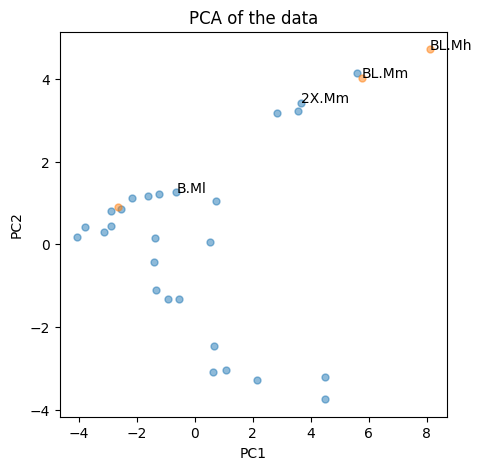

DBTL_A shape: (27, 10)
DBTL_B shape: (3, 10)


In [66]:
# Load the data
DBTL_A = ["2X.Mh", "B.Lm", "2X.Ll", "A.Mm", "B.Ll", "A.Mh", "2X.Lm", "A.Hl", "2X.Hh", "B.Ml", "B.Mm", "2X.Lh", "B.Mh", "2X.Hl", "B.Hl", "2X.Ml", "B.Hm", "B.Lh", "B.Hh", "A.Ll", "A.Hm", "2X.Mm", "A.Hh", "A.Ml", "A.Lm", "A.Lh", "2X.Hm"]
DBTL_B = ["BL.Mm", "BL.Mh", "BL.Ml"]
FILENAME = "preprocessed_Limonene_data.csv"

df = pd.read_csv(FILENAME, index_col=0)

inputs = df.drop(columns=["Limonene"]).columns.values.tolist()
outputs = ["Limonene"]

df_A = df.loc[DBTL_A]
df_B = df.loc[DBTL_B]

# PCA
pca, df_A_pca = pca_for_visualization(df_A, n_components=2)
df_B_pca = pd.DataFrame(pca.transform(df_B.drop(outputs, axis=1)), columns=["PC1", "PC2"], index=df_B.index)
df_B_pca[outputs] = df_B[outputs].values

# Plot PCA
plot_pca(df_A_pca, df_B_pca)

print(f"DBTL_A shape: {df_A.shape}")
print(f"DBTL_B shape: {df_B.shape}")

In [67]:
# Data scaling and scaler creation
dfin = df_A[inputs]
dfout = df_A[outputs]

x_offset, x_factor = dfin.mean().to_dict(), dfin.std().to_dict()
y_offset, y_factor = dfout.mean().to_dict(), dfout.std().to_dict()

dfin = (dfin - dfin.mean()).divide(dfin.std())
dfout = (dfout - dfout.mean()).divide(dfout.std())

scaled_lb = dfin.min()[inputs].values
scaled_ub = dfin.max()[inputs].values

scaler = OffsetScaling(
        offset_inputs={i: x_offset[inputs[i]] for i in range(len(inputs))},
        factor_inputs={i: x_factor[inputs[i]] for i in range(len(inputs))},
        offset_outputs={i: y_offset[outputs[i]] for i in range(len(outputs))},
        factor_outputs={i: y_factor[outputs[i]] for i in range(len(outputs))}
    )

scaled_input_bounds = {i: (scaled_lb[i], scaled_ub[i]) for i in range(len(inputs))}

In [68]:
def tune_and_train_rf(X_train, y_train):
    param_grid = {
        "n_estimators": np.linspace(3, 100, 100, dtype=int),
        "max_depth": np.linspace(2, 25, 100, dtype=int),
        "min_samples_split": np.linspace(0.1, 1.0, 100),
        "min_samples_leaf": np.linspace(0.1, 0.5, 100)
    }
    
    grid = RandomizedSearchCV(RandomForestRegressor(), param_distributions=param_grid,
                                n_iter=500, cv=3, verbose=3, n_jobs=-1)
    grid.fit(X_train, y_train)
    return grid.best_estimator_

def tune_and_train_gbt(X_train, y_train):
    param_grid = {
        "n_estimators": np.linspace(3, 100, 100, dtype=int),
        "max_depth": np.linspace(2, 25, 100, dtype=int),
        "min_samples_split": np.linspace(0.1, 1.0, 100),
        "min_samples_leaf": np.linspace(0.1, 0.5, 100)
    }
    
    grid = RandomizedSearchCV(GradientBoostingRegressor(), param_distributions=param_grid,
                                n_iter=500, cv=3, verbose=3, n_jobs=-1)
    grid.fit(X_train, y_train)
    return grid.best_estimator_

In [69]:
# X_train = df_A.drop(columns=["Limonene"]).values
# y_train = df_A["Limonene"].values

X_train = dfin.values
y_train = dfout.values.ravel()

In [70]:
# dtr = RandomForestRegressor()
# dtr.fit(X_train, y_train)

dtr = tune_and_train_rf(X_train, y_train)
# dtr = tune_and_train_gbt(X_train, y_train)

cv_score = cross_val_score(dtr, X_train, y_train, scoring='neg_mean_absolute_error', cv=5)
print(f"CV Score: {-cv_score.mean()}")

float_tensor_type = FloatTensorType([None, X_train.shape[1]])
initial_types = [("float_input", float_tensor_type)]
try:
    onnx_model = convert_sklearn(dtr, initial_types=initial_types)
except Exception:
    onnx_model = convert_xgboost(dtr, initial_types=initial_types)

results = pd.DataFrame({"pred": dtr.predict(X_train), "true": y_train})

Fitting 3 folds for each of 500 candidates, totalling 1500 fits
CV Score: 0.8192410478554649


In [71]:
def add_tree_model(opt_model, onnx_model, scaler, scaled_input_bounds):
    # init omlt block and gbt model based on the onnx format
    opt_model.gbt = OmltBlock()
    gbt_model = GradientBoostedTreeModel(onnx_model, scaling_object=scaler, scaled_input_bounds=scaled_input_bounds)

    # omlt uses a big-m formulation to encode the tree models
    formulation = GBTBigMFormulation(gbt_model)
    opt_model.gbt.build_formulation(formulation)


opt_model = pe.ConcreteModel()
add_tree_model(opt_model, onnx_model, scaler, scaled_input_bounds)

# Add objective and constraints
opt_model.obj = pe.Objective(expr=opt_model.gbt.outputs[0], sense=pe.maximize)

Q40322_MENSP_idx = inputs.index('Q40322_MENSP')
opt_model.cons = pe.Constraint(expr=opt_model.gbt.inputs[Q40322_MENSP_idx] >= 8)

solver = pe.SolverFactory("ipopt")
status = solver.solve(opt_model, tee=True)

Ipopt 3.11.1: 
==> Warning: Treating 83 binary and 0 integer variables as continous.


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

NOTE: You are using Ipopt by default with the MUMPS linear solver.
      Other linear solvers might be more efficient (see Ipopt documentation).


This is Ipopt version 3.11.1, running with linear solver mumps.

Number of nonzeros in equality constraint Jacobian...:      321
Number of nonzeros in inequality constraint Jacobian.:     1109
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      253
                     variables with only lower bounds:   

In [72]:
print(f"Objective value {opt_model.gbt.outputs[0].value}")

next_x = [opt_model.gbt.inputs[idx].value for idx in range(len(opt_model.gbt.inputs))]
next_x = pd.DataFrame(
    data=next_x, index=df_A.columns.drop("Limonene"), columns=["Value"]
)
next_x

Objective value 71.15870135626288


,Value
MVD1_YEAST,1.226221
Q40322_MENSP,8.911809
IDI_ECOLI,2.567641
ATOB_ECOLI,0.226875
Q8LKJ3_ABIGR,2.290010
Q9FD87_STAAU,0.810112
Q9FD86_STAAU,0.589027
KIME_YEAST,0.253013
ERG8_YEAST,0.805385


C:\Users\mexis\AppData\Local\Temp\ipykernel_25788\4149674075.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.annotate(txt, (df["PC1"][i], df["PC2"][i]))


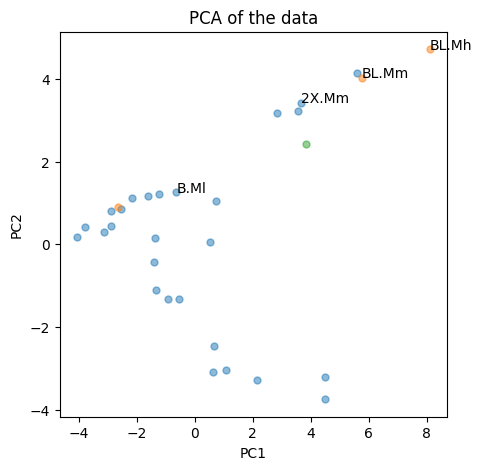

In [83]:
new_design = next_x.T

new_design_pca = pd.DataFrame(pca.transform(new_design), columns=["PC1", "PC2"], index=new_design.index)
new_design_pca[outputs] = dtr.predict(new_design.values)

plot_pca(df_A_pca, df_B_pca, new_design_pca, threshold=100)